# 2019 3rd ML Month : Car Class Classification
## 목차
1. 데이터 탐색(Data exploration)
2. 모델링(Modeling)
3. 예측(Prediction)

In [1]:
# import libraries
import gc
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from keras import backend as K

# ignore warnings
warnings.filterwarnings('ignore')

# set figuresize
plt.rcParams['figure.figsize'] = (12,10)

# set random seed
RANDOM_SEED = 35

Using TensorFlow backend.


In [2]:
K.image_data_format()

'channels_last'

**File load**
<br>
주어진 파일을 확인하고 로드합니다.

In [3]:
# 데이터 경로 설정
DATA_PATH = './input'
os.listdir(DATA_PATH)

['class.csv',
 'sample_submission.csv',
 'test',
 'test.csv',
 'test_crop',
 'train',
 'train.csv',
 'train_crop']

In [4]:
# 이미지 경로 설정
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

### 1. 데이터 탐색(Data Exploration)
Data Description에 나와 있는 컬럼 별 세부 설명입니다.
* img_file - 데이터 셋의 각 로우와 연결되는 이미지 파일 이름
* bbox_x1 - 바운딩 박스 x1 좌표(좌상단 x)
* bbox_y1 - 바운딩 박스 y1 좌표(좌상단 y)
* bbox_x2 - 바운딩 박스 x2 좌표(우하단 x)
* bbox_y2 - 바운딩 박스 y2 좌표(우하단 y)
* class - 예측하려는 차종(Target)
* id - 각 데이터 셋에 기입 되어 있는 클래스 id
* name - 클래스 id에 대응되는 실제 차종 레이블

In [5]:
# laod csv files
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [6]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [7]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [8]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


<br>
먼저 데이터 누락이 있는지 확인해 보도록 하겠습니다.

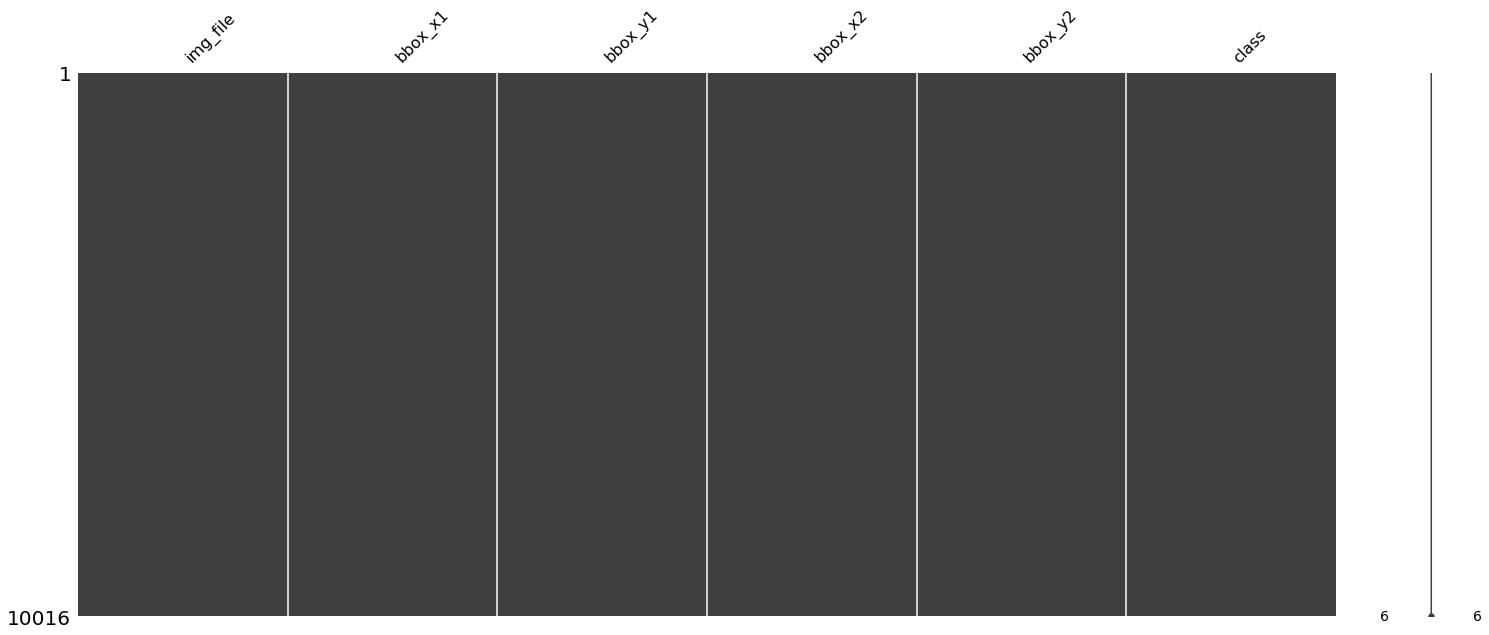

In [9]:
import missingno as msno
msno.matrix(df_train)

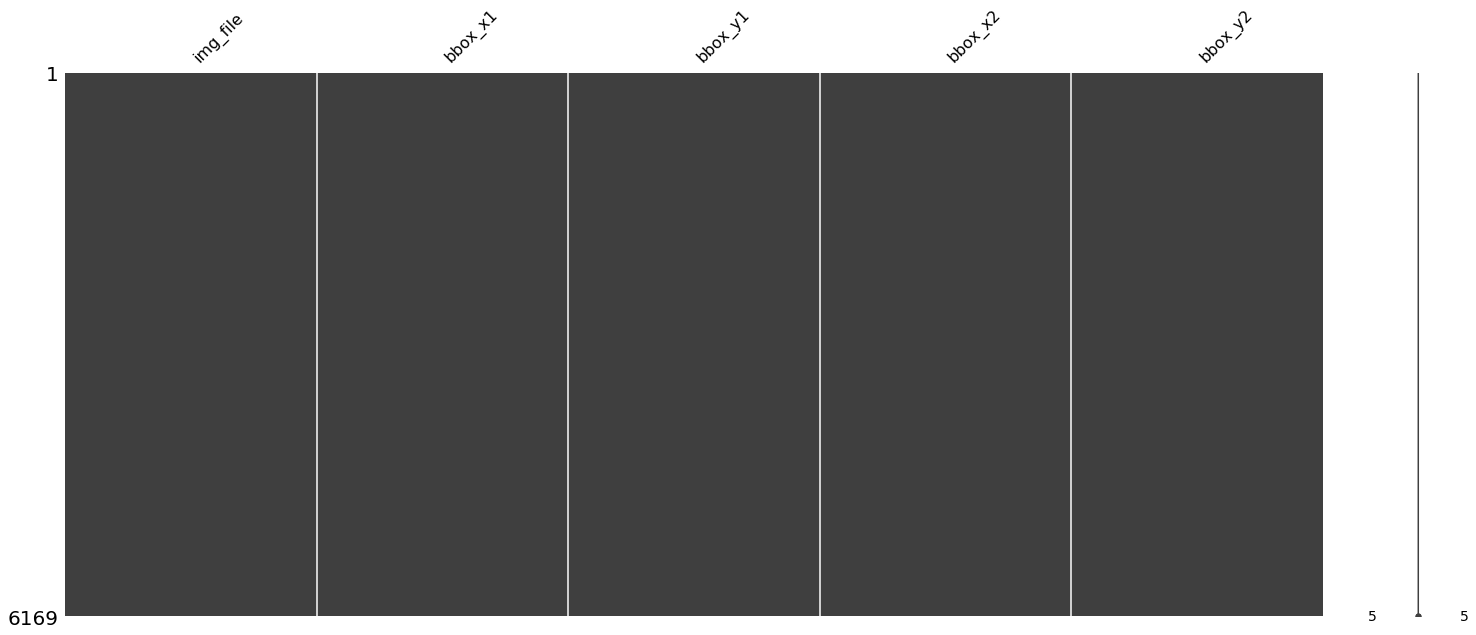

In [10]:
msno.matrix(df_test)

In [11]:
if set(list(df_train['img_file'])) == set(os.listdir(TRAIN_IMG_PATH)):
    print('Train 누락 없음!')
else:
    print('Train 누락 있음!')

if set(list(df_test['img_file'])) == set(os.listdir(TEST_IMG_PATH)):
    print('Test 누락 없음!')
else:
    print('Test 누락 있음!')

Train 누락 없음!
Test 누락 없음!


In [12]:
# Data 갯수
print('Number of train data : {}'.format(df_train.shape[0]))
print('Number of test data : {}'.format(df_test.shape[0]))

Number of train data : 10016
Number of test data : 6169


In [13]:
# 타겟의 개수
print('타겟 클래스 총 개수 : {}'.format(df_class.shape[0]))
print('Train 데이터의 클래스 총 개수 : {}'.format(df_train['class'].unique().shape[0]))

타겟 클래스 총 개수 : 196
Train 데이터의 클래스 총 개수 : 196


위와 같이 결측 데이터도 없고, 누락된 데이터 역시 없어보입니다.

**Class Distribution**
<br>
분류 문제에서 가장 먼저 의심해봐야 할 부분이 바로 Target Class의 분포입니다. 학습에 사용해야 하는 Train Set의 타겟 분포를 확인해서 밸런스가 어느정도인지 체크해야 합니다.

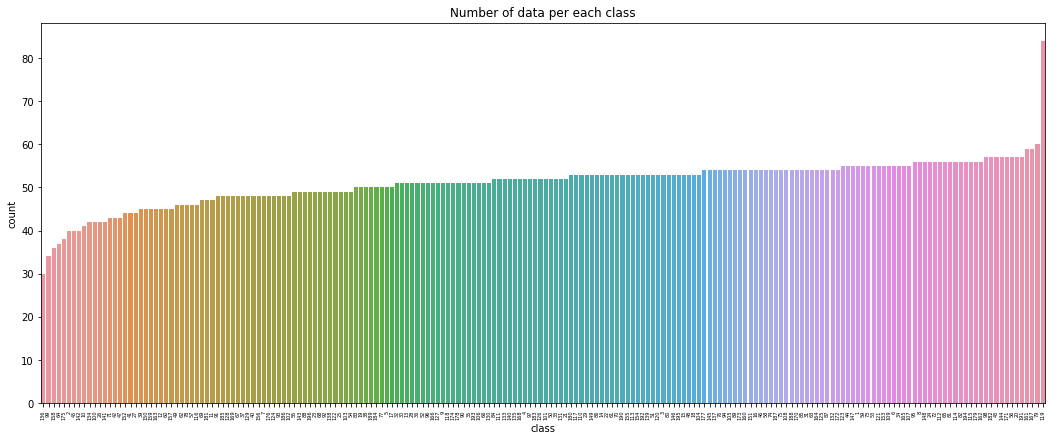

In [14]:
plt.figure(figsize=(18,7))
sns.countplot(df_train['class'], order=df_train['class'].value_counts(ascending=True).index)
plt.title('Number of data per each class')
plt.xticks(rotation=90, fontsize=5)
plt.show()

In [15]:
cntEachClass = df_train['class'].value_counts(ascending=False)
print('Class with most count : {}'.format(cntEachClass.index[0]))
print('Most Count : {}'.format(cntEachClass.max()))

print('Class with fewest count : {}'.format(cntEachClass.index[-1]))
print('Fewest Count : {}'.format(cntEachClass.min()))

print('Mean : {}'.format(cntEachClass.mean()))

Class with most count : 119
Most Count : 84
Class with fewest count : 136
Fewest Count : 30
Mean : 51.10204081632653


In [16]:
cntEachClass.describe()

count    196.000000
mean      51.102041
std        5.350274
min       30.000000
25%       48.750000
50%       52.000000
75%       54.000000
max       84.000000
Name: class, dtype: float64

대체적으로 카운트 수는 비슷합니다. 84번 클래스가 유독 카운트 숫자가 높고 평균은 51정도 입니다.

**Image Visualization**

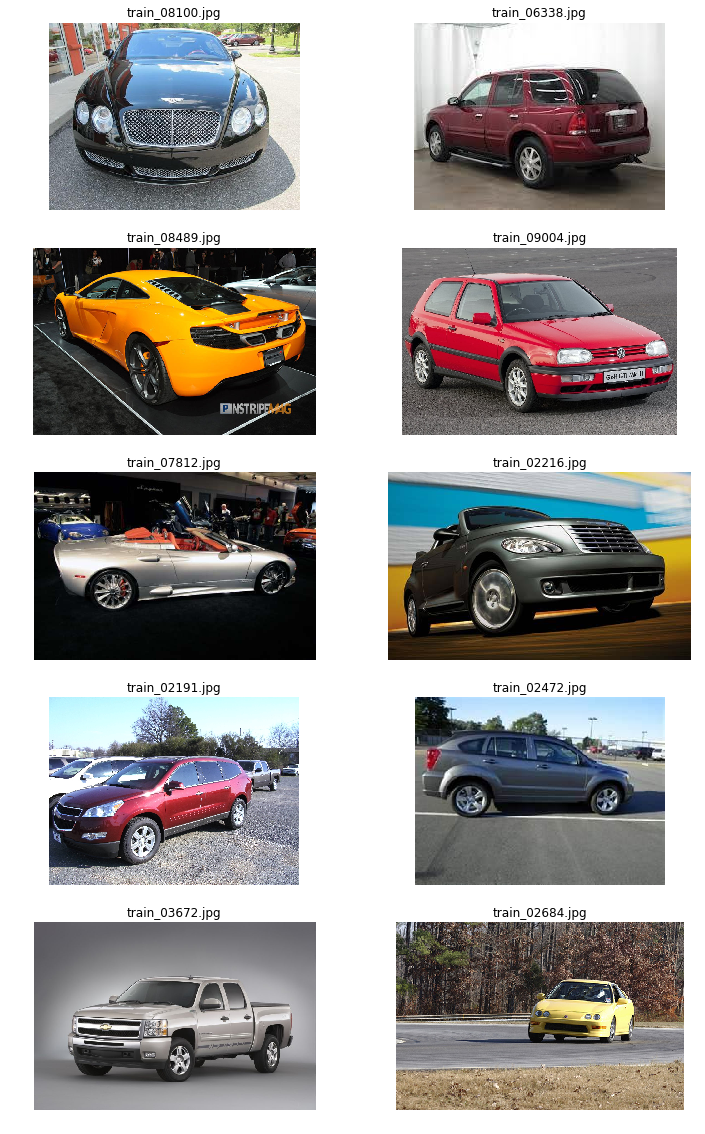

In [17]:
import cv2

mask = np.random.choice(df_train.shape[0], 10)

tmp_imgs = df_train['img_file'][mask]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = cv2.imread(os.path.join(TRAIN_IMG_PATH,f_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(5,2,num+1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

**Bounding Box**

In [18]:
def draw_rect(img, pos, color=None, thickness=1):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    cv2.rectangle(img=img, pt1=(x1,y1), pt2=(x2,y2), color=color, thickness=thickness)
    return img
    
def make_boxing_img(img_name):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    elif img_name.split('_')[0] == 'test':
        PATH = TEST_IMG_PATH
        data = df_test
        
    img = cv2.imread(os.path.join(TRAIN_IMG_PATH, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pos = data.loc[data['img_file'] == img_name, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    img = draw_rect(img, pos, color=(255,0,0), thickness=5)
    
    return img

(<matplotlib.image.AxesImage at 0x1e49cd96208>, (-0.5, 529.5, 306.5, -0.5))

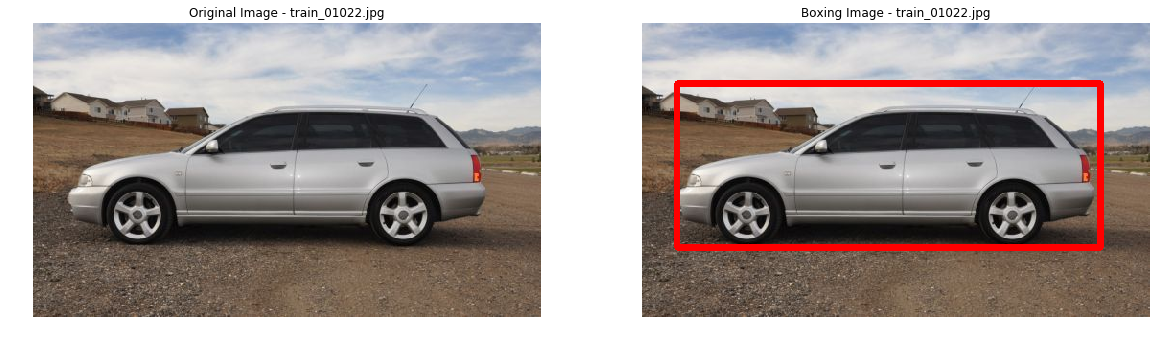

In [19]:
f_name = 'train_01022.jpg'

plt.figure(figsize=(20,10))
plt.subplot(121)
# Original image
original_img = cv2.imread(os.path.join(TRAIN_IMG_PATH, f_name))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.title('Original Image - {}'.format(f_name))
plt.imshow(original_img), plt.axis('off')

# Image included bounding box
plt.subplot(122)
boxing_im = make_boxing_img(f_name)
plt.title('Boxing Image - {}'.format(f_name))
plt.imshow(boxing_im), plt.axis('off')

### 2. 모델링
**K-fold Vaidation**

In [20]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPool2D, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score

In [21]:
# 모델링을 위한 데이터 준비
df_train['class'] = df_train['class'].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

In [22]:
df_train.shape, df_test.shape

((10016, 2), (6169, 1))

이제 케라스의 제너레이터를 사용해 데이터를 준비해보도록 합시다.

In [23]:
# Train, Test spllit
X_train, X_val = train_test_split(df_train, train_size=0.95, random_state=RANDOM_SEED)

In [24]:
X_train.shape, X_val.shape

((9515, 2), (501, 2))

In [25]:
# Parameters
img_size = (256, 256)
epochs = 20
batch_size = 16
train_size = len(X_train)
val_size = len(X_val)

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = False,
    zoom_range = 0.10,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [26]:
TRAIN_IMG_PATH

'./input\\train'

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    directory = TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    interploation = 'bicubic'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = X_val,
    directory = TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    interploation = 'bicubic'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = TEST_IMG_PATH,
    x_col = 'img_file',
    y_col = None,
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    interploation = 'bicubic'
)

Found 9515 validated image filenames belonging to 196 classes.
Found 501 validated image filenames belonging to 181 classes.
Found 6169 validated image filenames.


In [28]:
def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

def build_resnet50_model(include_top=False, input_shape=(256,256,3), fine_tuning=True):
    resnet_model = ResNet50(include_top=include_top, input_shape = (256,256,3))
    
    if fine_tuning:
        # Freese layers
        fr_layer_name = 'res5c_branch2a'
        set_trainable = False
    
        for layer in resnet_model.layers:
            if not layer.name == fr_layer_name:
                set_trainable = True
            
            layer.trainable = set_trainable
            
    last_1dconv_1 = Conv2D(1024, 1, activation='relu')(resnet_model.output)
    globla_max_pool = GlobalMaxPool2D()(last_1dconv_1)
    last_Dense_1 = Dense(512, activation='relu')(globla_max_pool)
    last_Dense_2 = Dense(196, activation='softmax')(last_Dense_1)
    
    # compile
    model = Model(resnet_model.input, last_Dense_2)
    return model

In [29]:
model = build_resnet50_model()

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_7 (Add)                     (None, 32, 32, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 32, 32, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 16, 16, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 16, 16, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_44 (Activation)      (None, 8, 8, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 8, 8, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 8, 8, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 8, 8, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 8, 8, 2048)   1050624     activation_45[0][0]              
__________

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [32]:
# Define steps per epoch
def get_steps(num_samples, batch_size):
    if (num_samples // batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [33]:
if not os.path.exists('./model'):
    os.mkdir('./model')
    
checkpoint_filename = 'renet_model_{}_epochs.h5'.format(epochs)

In [34]:
patience = 5
# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.5,
    patience=patience,
    verbose=1,
    mode='min',
    min_lr = 0.0000001
)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.000001,
    patience = patience,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    filepath = os.path.join('./model', checkpoint_filename),
    monitor='val_loss',
    verbose=1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'min',
    period = 5
)

In [35]:
get_steps(val_size, batch_size)

32

In [37]:
gc.collect()
callbacks = [reduce_lr, early_stopping, model_checkpoint]


model.fit_generator(
    generator = train_generator,
    steps_per_epoch = get_steps(train_size, batch_size),
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_generator,
    validation_steps = get_steps(val_size, batch_size),
    verbose=1
)

gc.collect()

Epoch 1/20


202/595 [=========>....................] - ETA: 4:44 - loss: 5.2779 - acc: 0.0000e+0 - ETA: 3:35 - loss: 5.2583 - acc: 0.0000e+0 - ETA: 3:19 - loss: 5.2716 - acc: 0.0000e+0 - ETA: 3:23 - loss: 5.3062 - acc: 0.0000e+0 - ETA: 3:14 - loss: 5.3151 - acc: 0.0000e+0 - ETA: 3:07 - loss: 5.2978 - acc: 0.0000e+0 - ETA: 3:05 - loss: 5.3065 - acc: 0.0000e+0 - ETA: 3:01 - loss: 5.3074 - acc: 0.0000e+0 - ETA: 3:01 - loss: 5.3035 - acc: 0.0000e+0 - ETA: 2:58 - loss: 5.3007 - acc: 0.0000e+0 - ETA: 2:58 - loss: 5.3036 - acc: 0.0000e+0 - ETA: 2:55 - loss: 5.3044 - acc: 0.0000e+0 - ETA: 2:56 - loss: 5.3026 - acc: 0.0000e+0 - ETA: 2:55 - loss: 5.2995 - acc: 0.0000e+0 - ETA: 2:53 - loss: 5.2982 - acc: 0.0000e+0 - ETA: 2:53 - loss: 5.2983 - acc: 0.0000e+0 - ETA: 2:53 - loss: 5.2966 - acc: 0.0000e+0 - ETA: 2:52 - loss: 5.2947 - acc: 0.0035    - ETA: 2:51 - loss: 5.2950 - acc: 0.003 - ETA: 2:52 - loss: 5.2963 - acc: 0.006 - ETA: 2:52 - loss: 5.2945 - acc: 0.006 - ETA: 2:52 - loss: 5.2919 - acc: 0.005 - ETA: 

594/595 [============================>.] - ETA: 58s - loss: 5.2907 - acc: 0.00 - ETA: 57s - loss: 5.2906 - acc: 0.00 - ETA: 57s - loss: 5.2907 - acc: 0.00 - ETA: 57s - loss: 5.2906 - acc: 0.00 - ETA: 57s - loss: 5.2903 - acc: 0.00 - ETA: 56s - loss: 5.2904 - acc: 0.00 - ETA: 56s - loss: 5.2904 - acc: 0.00 - ETA: 56s - loss: 5.2905 - acc: 0.00 - ETA: 55s - loss: 5.2906 - acc: 0.00 - ETA: 55s - loss: 5.2909 - acc: 0.00 - ETA: 55s - loss: 5.2910 - acc: 0.00 - ETA: 54s - loss: 5.2910 - acc: 0.00 - ETA: 54s - loss: 5.2909 - acc: 0.00 - ETA: 54s - loss: 5.2909 - acc: 0.00 - ETA: 53s - loss: 5.2909 - acc: 0.00 - ETA: 53s - loss: 5.2908 - acc: 0.00 - ETA: 53s - loss: 5.2908 - acc: 0.00 - ETA: 53s - loss: 5.2908 - acc: 0.00 - ETA: 52s - loss: 5.2908 - acc: 0.00 - ETA: 52s - loss: 5.2908 - acc: 0.00 - ETA: 52s - loss: 5.2907 - acc: 0.00 - ETA: 51s - loss: 5.2907 - acc: 0.00 - ETA: 51s - loss: 5.2907 - acc: 0.00 - ETA: 51s - loss: 5.2906 - acc: 0.00 - ETA: 51s - loss: 5.2906 - acc: 0.00 - ETA: 50

ValueError: Error when checking target: expected dense_2 to have shape (196,) but got array with shape (181,)